In [1]:
# Import libraries for data handling
import pandas as pd
from google.colab import drive

# Import libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Import libraries for vectorization and modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

# Import libraries for word frequency analysis and visualization
from collections import Counter
import matplotlib.pyplot as plt

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Added to fix LookupError
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Define DataLoader class for loading the dataset
class DataLoader:
    def __init__(self, file_path):
        """
        Initialize DataLoader with the path to the CSV file.

        Args:
            file_path (str): Path to the CSV file in Google Drive
        """
        self.file_path = file_path
        self.data = None

    def load_data(self):
        """
        Load the IMDB dataset from Google Drive and return as DataFrame.

        Returns:
            pandas.DataFrame: Loaded dataset
        """
        # Mount Google Drive
        drive.mount('/content/drive', force_remount=True)

        # Load CSV file
        self.data = pd.read_csv(self.file_path)

        # Display sample of the data
        print("Sample of the dataset:")
        print(self.data.head())

        # Display dataset info
        print("\nDataset Info:")
        print(self.data.info())

        return self.data

# Instantiate DataLoader and load the dataset
file_path = "/content/drive/MyDrive/Elevvo_Pathway/IMDB Dataset.csv"
data_loader = DataLoader(file_path)
data = data_loader.load_data()

Mounted at /content/drive
Sample of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [3]:
# Define TextPreprocessor class for cleaning text data
class TextPreprocessor:
    def __init__(self):
        """
        Initialize TextPreprocessor with NLTK stop words.
        """
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """
        Clean a single text string by applying preprocessing steps.

        Args:
            text (str): Input text to clean

        Returns:
            str: Cleaned text
        """
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Tokenize text
        words = word_tokenize(text)
        # Remove stop words
        words = [word for word in words if word not in self.stop_words]
        # Join words back into a string
        return ' '.join(words)

    def preprocess(self, texts):
        """
        Preprocess a list of texts.

        Args:
            texts (list): List of text strings to preprocess

        Returns:
            list: List of cleaned text strings
        """
        return [self.clean_text(text) for text in texts]

# Instantiate TextPreprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing to the 'review' column and add a new column 'processed_text'
data['processed_text'] = preprocessor.preprocess(data['review'])

# Display sample of the dataset with the new column
print("Sample of the dataset with processed text:")
print(data[['review', 'processed_text', 'sentiment']].head())

Sample of the dataset with processed text:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      processed_text sentiment  
0  one reviewers mentioned watching oz episode yo...  positive  
1  wonderful little production br br filming tech...  positive  
2  thought wonderful way spend time hot summer we...  positive  
3  basically theres family little boy jake thinks...  negative  
4  petter matteis love time money visually stunni...  positive  


In [4]:
# Define SentimentAnalyzer class for vectorization and model training
class SentimentAnalyzer:
    def __init__(self):
        """
        Initialize SentimentAnalyzer with TF-IDF vectorizer and classifiers.
        """
        self.vectorizer = TfidfVectorizer(max_features=5000)
        self.logistic_model = LogisticRegression(max_iter=1000)
        self.naive_bayes_model = MultinomialNB()
        self.X_train_tfidf = None
        self.X_test_tfidf = None
        self.y_train = None
        self.y_test = None

    def prepare_data(self, texts, labels):
        """
        Prepare data by converting texts to TF-IDF and splitting into train/test sets.

        Args:
            texts (list): List of preprocessed texts
            labels (list): List of sentiment labels
        """
        # Convert labels to binary (positive=1, negative=0)
        labels = [1 if label == 'positive' else 0 for label in labels]

        # Convert texts to TF-IDF features
        self.X_tfidf = self.vectorizer.fit_transform(texts)

        # Split data into training and testing sets
        self.X_train_tfidf, self.X_test_tfidf, self.y_train, self.y_test = train_test_split(
            self.X_tfidf, labels, test_size=0.2, random_state=42
        )

    def train_models(self):
        """
        Train Logistic Regression and Naive Bayes models.
        """
        # Train Logistic Regression
        self.logistic_model.fit(self.X_train_tfidf, self.y_train)
        print("Logistic Regression model trained.")

        # Train Naive Bayes
        self.naive_bayes_model.fit(self.X_train_tfidf, self.y_train)
        print("Naive Bayes model trained.")

    def evaluate_models(self):
        """
        Evaluate both models using Accuracy and F1-Score.

        Returns:
            dict: Evaluation metrics for both models
        """
        # Logistic Regression predictions
        lr_predictions = self.logistic_model.predict(self.X_test_tfidf)
        lr_accuracy = accuracy_score(self.y_test, lr_predictions)
        lr_f1 = f1_score(self.y_test, lr_predictions)

        # Naive Bayes predictions
        nb_predictions = self.naive_bayes_model.predict(self.X_test_tfidf)
        nb_accuracy = accuracy_score(self.y_test, nb_predictions)
        nb_f1 = f1_score(self.y_test, nb_predictions)

        # Return evaluation metrics
        metrics = {
            'Logistic Regression': {'Accuracy': lr_accuracy, 'F1-Score': lr_f1},
            'Naive Bayes': {'Accuracy': nb_accuracy, 'F1-Score': nb_f1}
        }
        return metrics


    def predict_text(self, text, model="logistic"):
        """
        Predict sentiment for a single text input.

        Args:
            text (str): Raw text input
            model (str): 'logistic' or 'naive'

        Returns:
            str: Predicted sentiment label
        """
        # Clean text
        cleaned = re.sub(r'<.*?>', '', text.lower())
        cleaned = re.sub(r'[^a-z\s]', '', cleaned)
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()

        # Vectorize
        vec = self.vectorizer.transform([cleaned])

        if model == "logistic":
            pred = self.logistic_model.predict(vec)[0]
        elif model == "naive":
            pred = self.naive_bayes_model.predict(vec)[0]
        else:
            raise ValueError("Model must be 'logistic' or 'naive'")

        return "Positive" if pred == 1 else "Negative"


    def show_confusion_matrix(self, model="logistic"):
        """
        Display confusion matrix for selected model.

        Args:
            model (str): 'logistic' or 'naive'
        """
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

        if model == "logistic":
            preds = self.logistic_model.predict(self.X_test_tfidf)
        elif model == "naive":
            preds = self.naive_bayes_model.predict(self.X_test_tfidf)
        else:
            raise ValueError("Model must be 'logistic' or 'naive'")

        cm = confusion_matrix(self.y_test, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
        disp.plot(cmap="Blues")



# Instantiate SentimentAnalyzer
analyzer = SentimentAnalyzer()

# Prepare data (using processed_text and sentiment columns)
analyzer.prepare_data(data['processed_text'], data['sentiment'])

# Train both models
analyzer.train_models()

# Evaluate models and print results
metrics = analyzer.evaluate_models()
print("\nModel Evaluation Results:")
for model, scores in metrics.items():
    print(f"{model}:")
    print(f"  Accuracy: {scores['Accuracy']:.2f}")
    print(f"  F1-Score: {scores['F1-Score']:.2f}")

Logistic Regression model trained.
Naive Bayes model trained.

Model Evaluation Results:
Logistic Regression:
  Accuracy: 0.89
  F1-Score: 0.89
Naive Bayes:
  Accuracy: 0.85
  F1-Score: 0.85


Negative


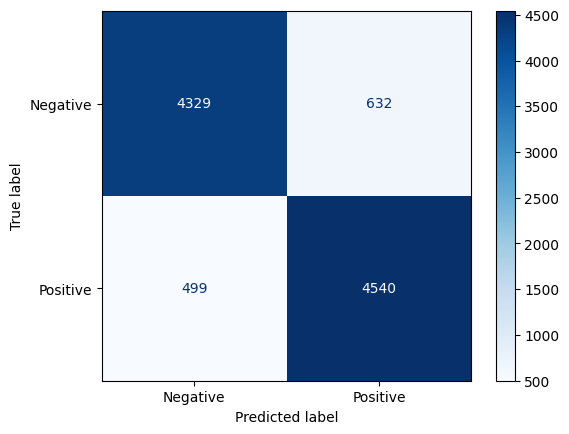

In [5]:
# Predict sentiment of new text
print(analyzer.predict_text("I hated this movie so much!", model="naive"))

# Show confusion matrix for logistic regression
analyzer.show_confusion_matrix(model="logistic")


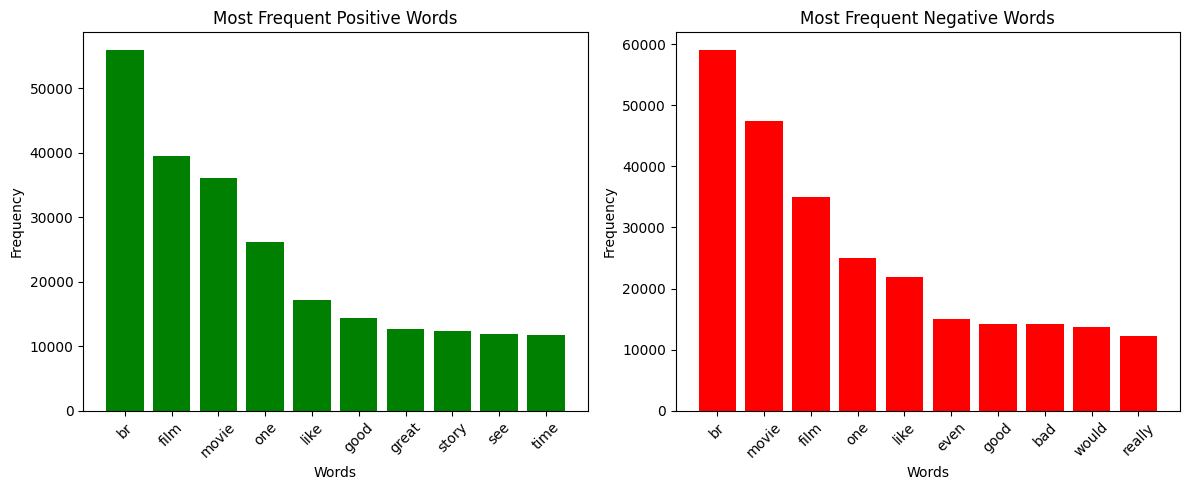

In [6]:
# Define WordFrequencyAnalyzer class for analyzing frequent words
class WordFrequencyAnalyzer:
    def __init__(self):
        """
        Initialize WordFrequencyAnalyzer.
        """
        pass

    def get_frequent_words(self, texts, labels, top_n=10):
        """
        Get the most frequent words for positive and negative reviews.

        Args:
            texts (list): List of preprocessed texts
            labels (list): List of sentiment labels
            top_n (int): Number of top words to return

        Returns:
            tuple: (positive_words, negative_words) as dictionaries with word frequencies
        """
        # Separate positive and negative texts
        positive_texts = [text for text, label in zip(texts, labels) if label == 'positive']
        negative_texts = [text for text, label in zip(texts, labels) if label == 'negative']

        # Count words in positive texts
        positive_words = Counter(' '.join(positive_texts).split())
        positive_words = dict(positive_words.most_common(top_n))

        # Count words in negative texts
        negative_words = Counter(' '.join(negative_texts).split())
        negative_words = dict(negative_words.most_common(top_n))

        return positive_words, negative_words

    def plot_frequent_words(self, positive_words, negative_words):
        """
        Plot bar charts for frequent positive and negative words.

        Args:
            positive_words (dict): Dictionary of positive word frequencies
            negative_words (dict): Dictionary of negative word frequencies
        """
        # Set up the plotting area with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Plot positive words
        ax1.bar(positive_words.keys(), positive_words.values(), color='green')
        ax1.set_title('Most Frequent Positive Words')
        ax1.set_xlabel('Words')
        ax1.set_ylabel('Frequency')
        ax1.tick_params(axis='x', rotation=45)

        # Plot negative words
        ax2.bar(negative_words.keys(), negative_words.values(), color='red')
        ax2.set_title('Most Frequent Negative Words')
        ax2.set_xlabel('Words')
        ax2.set_ylabel('Frequency')
        ax2.tick_params(axis='x', rotation=45)

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

# Instantiate WordFrequencyAnalyzer
word_analyzer = WordFrequencyAnalyzer()

# Get frequent words for positive and negative reviews
positive_words, negative_words = word_analyzer.get_frequent_words(data['processed_text'], data['sentiment'])

# Plot the frequent words
word_analyzer.plot_frequent_words(positive_words, negative_words)